In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA

# ACF and PACF functions to test for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

About Dataset
Data is coming from https://www.kaggle.com/datasets/bertiemackie/daily-website-users.
It contains the number of unique customers who logged in to their accounts on a website. The user_numbers column shows this count.

In [2]:
webusers_df = pd.read_csv("C:\\Users\\karol\\Downloads\\archive (3)\\users.csv", header = 0,
                     names = ['date', 'measure','user_numbers'],
                     index_col = 0)

In [3]:
webusers_df.head()

,date,measure,user_numbers
0,2019-01-01,daily_users,67
1,2019-01-02,daily_users,51
2,2019-01-03,daily_users,58
3,2019-01-04,daily_users,71
4,2019-01-05,daily_users,28


In [4]:
webusers_df.tail()

,date,measure,user_numbers
1092,2021-12-28,daily_users,98
1093,2021-12-29,daily_users,91
1094,2021-12-30,daily_users,70
1095,2021-12-31,daily_users,75
1096,2022-01-01,daily_users,50


In [5]:
webusers_df.shape

(1097, 3)

In [6]:
#checking the missing values per column

missing_values=pd.DataFrame(webusers_df.isnull().any(),columns=(['Nulls']))
missing_values['Nan_count']=pd.DataFrame(webusers_df.isnull().sum())
missing_values['Nan_percentage']=round((webusers_df.isnull().mean()*100),2)
print(missing_values.sort_values(by='Nan_percentage',ascending=False))

              Nulls  Nan_count  Nan_percentage
date          False          0             0.0
measure       False          0             0.0
user_numbers  False          0             0.0


Dataset has no missing values.

In [3]:
# Converting the DataFrame into a Series object
# Proper time stamp with daily frequency
webusersts = pd.Series(webusers_df['user_numbers'].values,
                     index = pd.date_range('2019-01-01',
                                           periods = 1097,
                                           freq = 'D'))

In [8]:
webusersts.head()

2019-01-01    67
2019-01-02    51
2019-01-03    58
2019-01-04    71
2019-01-05    28
Freq: D, dtype: int64

The Statistics of Time Series

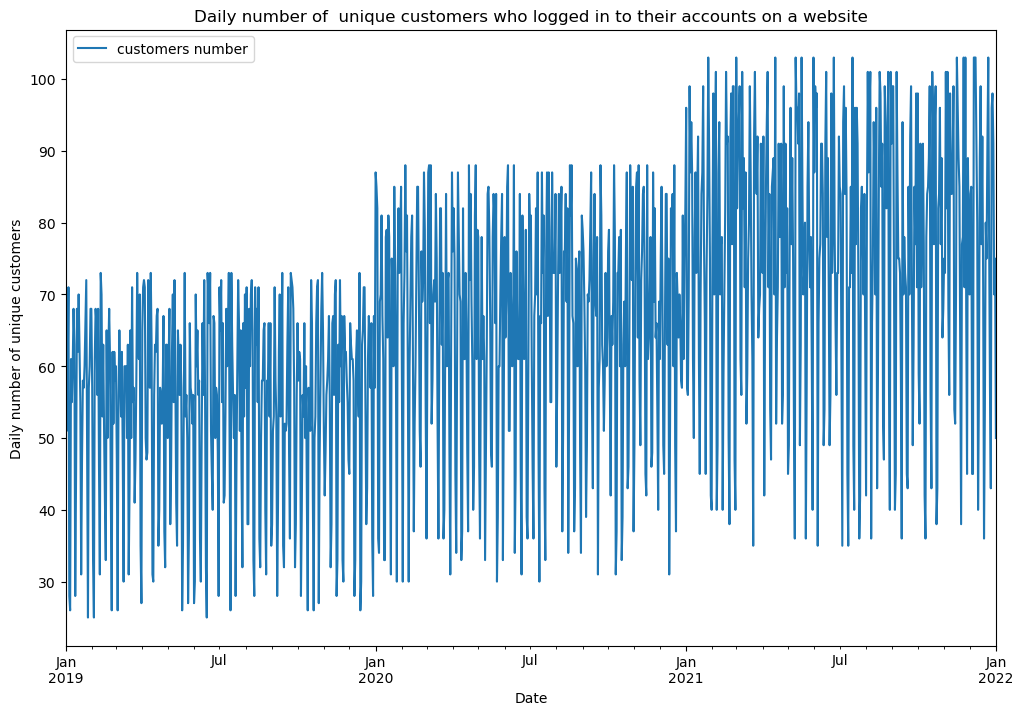

In [9]:
# Visualizing time series with line graph
plt.figure(figsize=(12,8))
webusersts.plot()
plt.title('Daily number of  unique customers who logged in to their accounts on a website')
plt.xlabel('Date')
plt.ylabel('Daily number of unique customers')
plt.legend(['customers number'])

We can observe existance of trend in the data. Each year the numbers are increasing and following similar pattern.

In [4]:
# Getting the cumulative total of webusersts
# The new object inherits the original index
cumsum_webusers = np.cumsum(webusersts)

In [5]:
cumsum_webusers.head()

2019-01-01     67
2019-01-02    118
2019-01-03    176
2019-01-04    247
2019-01-05    275
Freq: D, dtype: int64

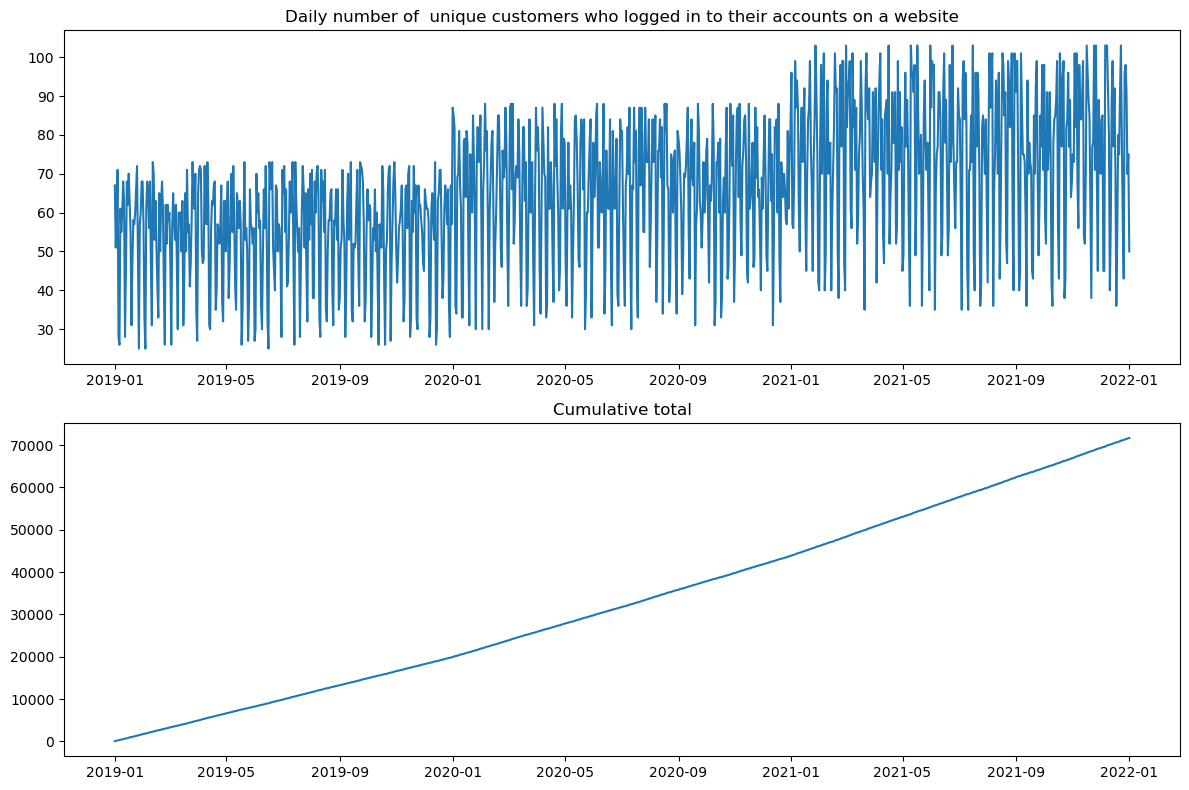

In [6]:
#Two plots in the same figure with subplots
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(webusersts)
plt.title('Daily number of  unique customers who logged in to their accounts on a website')

plt.subplot(2,1,2)
plt.plot(cumsum_webusers)
plt.title('Cumulative total')
plt.tight_layout()

In [7]:
#Chcecking the stationarity of Time series
# Custom stationarity test function
def stationarity_test(timeseries):
    """"Augmented Dickey-Fuller Test
    Test for Stationarity"""
    import pandas as pd
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag = "AIC")
    df_output = pd.Series(df_test[0:4],
                          index = ["Test Statistic", "p-value", "Number of Lags Used",
                                   "Number of Observations Used"])
    print(df_output)

In [8]:
stationarity_test(webusersts)

Results of Dickey-Fuller Test:
Test Statistic                   -1.449288
p-value                           0.558432
Number of Lags Used              20.000000
Number of Observations Used    1076.000000
dtype: float64


Dataset is not stationary, the p-value is more then 0.05 . From the graph above we saw already the presence of trend.

To use ARIMA model, we need to have stationary data, therefore we have to use Differencing.Is a popular method used to get rid of seasonality and trends. This is done by subtracting the current observation with the previous observation.

In [9]:
webusersts_diff = webusersts.diff().diff(12).dropna()

In [11]:
webusersts_diff.head()

2019-01-14    39.0
2019-01-15   -13.0
2019-01-16    -5.0
2019-01-17    36.0
2019-01-18    -6.0
Freq: D, dtype: float64

In [10]:
stationarity_test(webusersts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -9.745867e+00
p-value                        8.259352e-17
Number of Lags Used            2.200000e+01
Number of Observations Used    1.061000e+03
dtype: float64


Now the p-value is less then 0,05 and after differencing method, the data set is stationary.

Chcecking for autocorrelation for webusersts_diff

C:\Users\karol\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


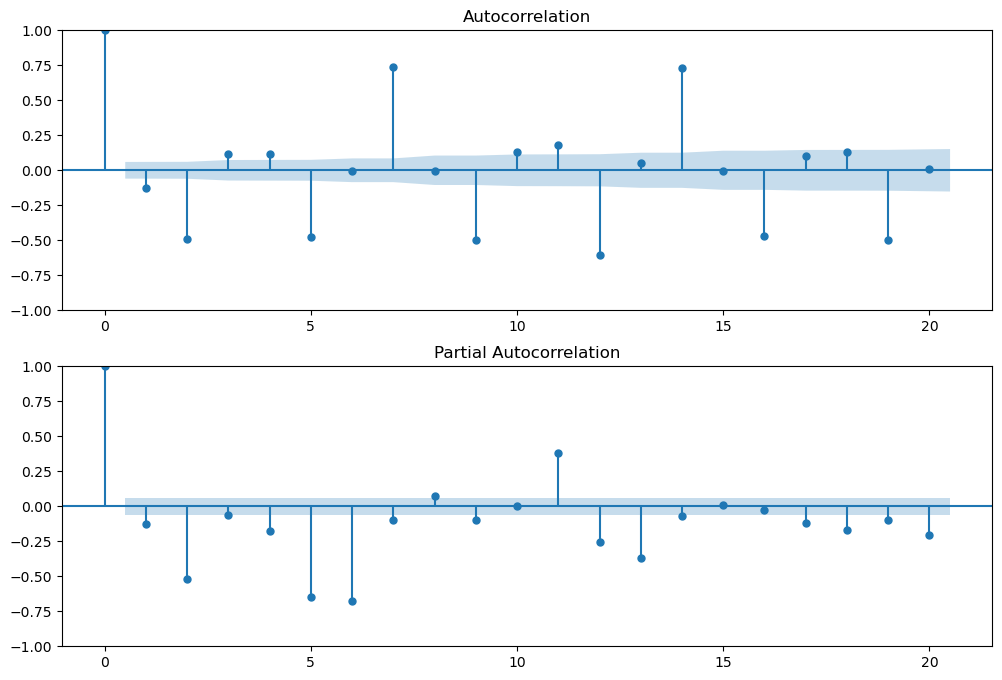

In [12]:
# ACF and PACF plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(webusersts_diff, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(webusersts_diff, lags=20, ax=ax2)

Most lags are autocorelated. I will try model ARIMA(6,0,0)

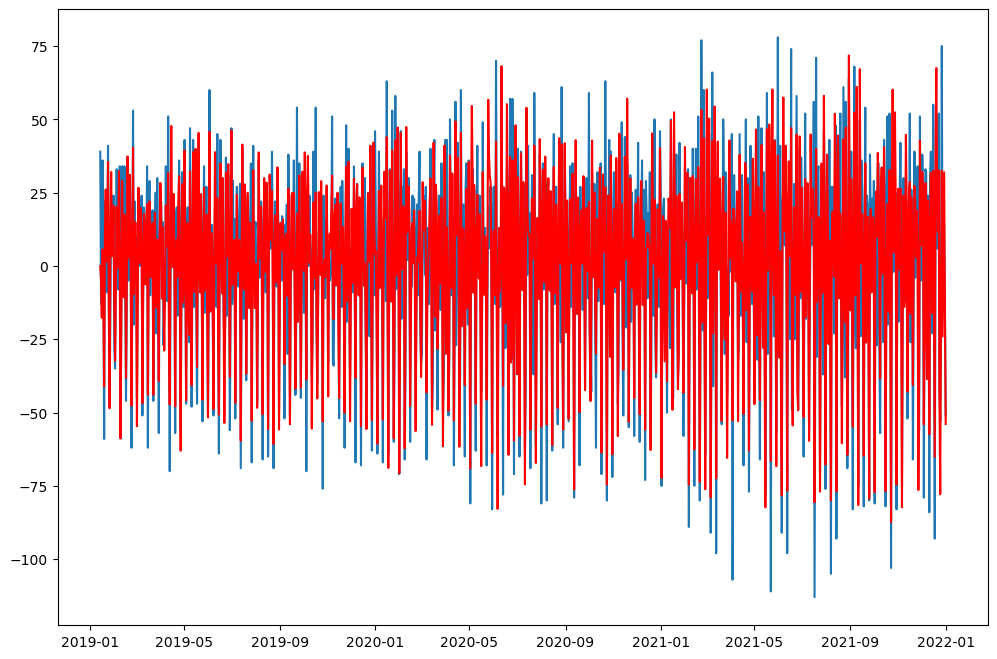

In [13]:
# ARIMA model setup
model = ARIMA(webusersts_diff, order=(6, 0, 0))  
results_AR6 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(webusersts_diff)
plt.plot(results_AR6.fittedvalues, color='red')

Model diagnostic on the residuals (Residuals=orginal data-fitted values)
To have a good model the residuals should have normal distribution, mean close to zero, autocorrelation (ACF and PACF plots).

In [20]:
webusersts_diff.tail()

2021-12-28   -13.0
2021-12-29    14.0
2021-12-30    14.0
2021-12-31   -13.0
2022-01-01   -51.0
Freq: D, dtype: float64

In [21]:
results_AR6.fittedvalues.tail()

2021-12-28   -24.044189
2021-12-29     6.078582
2021-12-30    31.917330
2021-12-31   -15.241330
2022-01-01   -53.880537
Freq: D, dtype: float64

In [22]:
results_AR6.resid.tail()

2021-12-28    11.044189
2021-12-29     7.921418
2021-12-30   -17.917330
2021-12-31     2.241330
2022-01-01     2.880537
Freq: D, dtype: float64

In [23]:
# Original series - fitted values = model residuals
(webusersts_diff - results_AR6.fittedvalues).tail()

2021-12-28    11.044189
2021-12-29     7.921418
2021-12-30   -17.917330
2021-12-31     2.241330
2022-01-01     2.880537
Freq: D, dtype: float64

In [24]:
# Checking if Residuals are close to a zero mean
np.mean(results_AR6.resid)

0.056624284049550895

 Residuals are close to a zero mean which is a good news.

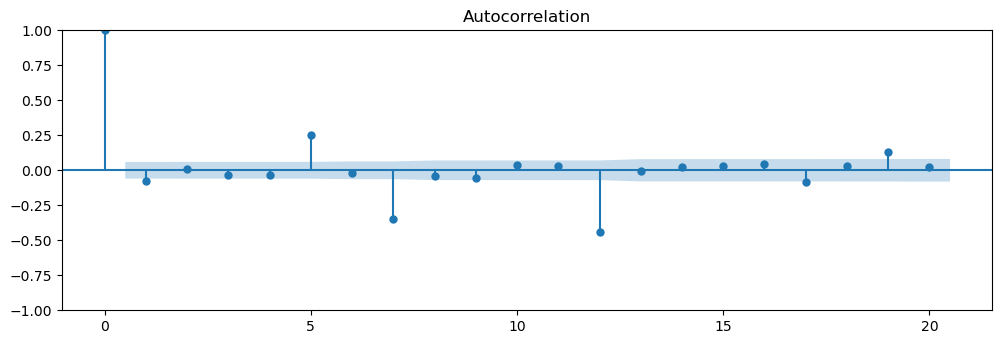

In [25]:
# ACF plot to test for autocorrelation in the residuals
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR6.resid, lags=20, ax=ax1)

C:\Users\karol\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


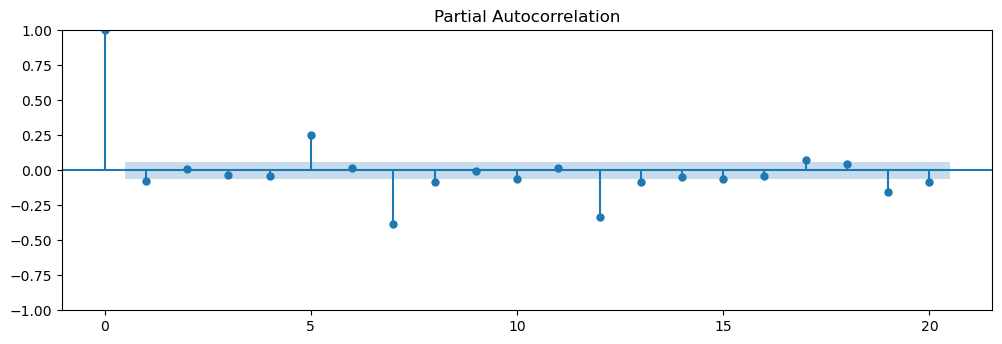

In [26]:
fig = plt.figure(figsize=(12,8))
ax2=fig.add_subplot(212)
fig=plot_pacf(results_AR6.resid, lags=20, ax=ax2)

Unfortunatly the first and 5 lags are autocorrelated.

In [27]:
# Custom function to test for a normal distribution
def resid_histogram(data):
    import matplotlib.pyplot as plt
    from numpy import linspace
    from scipy.stats import norm

    plt.figure(figsize=(10,6))
    plt.hist(data, bins = 'auto', density = True, rwidth = 0.85,
             label = 'Residuals')
    mean_resid, std_resid = norm.fit(data)
    xmin, xmax = plt.xlim()
    curve_length = linspace(xmin, xmax, 100)
    bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
    plt.plot(curve_length, bell_curve, 'm', linewidth = 2)
    plt.grid(axis='y', alpha = 0.2)
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid,2))+', Std = '+str(round(std_resid,2)))
    plt.show()

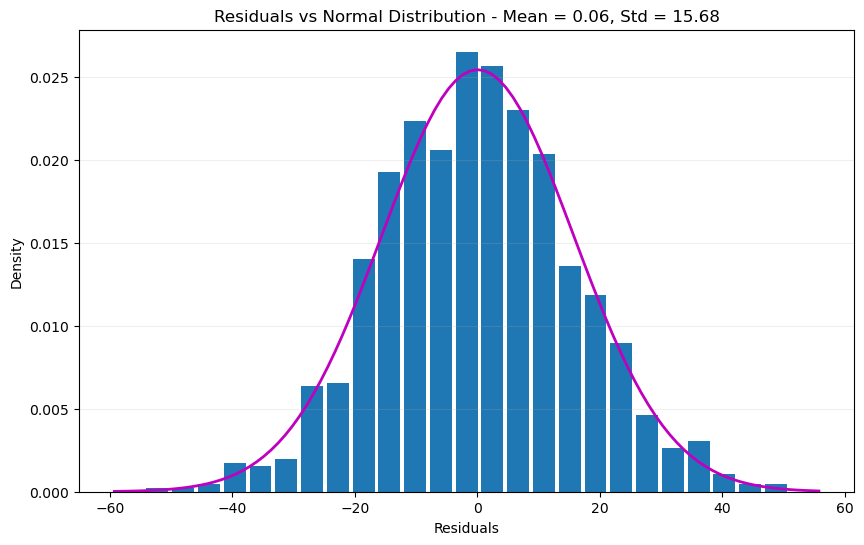

In [28]:
resid_histogram(results_AR6.resid)

Model Residual is close to normal distribution.

In [29]:
# Model diagnostics 
results_AR6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1084
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -4520.769
Date:                Mon, 20 May 2024   AIC                           9057.537
Time:                        21:01:50   BIC                           9097.444
Sample:                    01-14-2019   HQIC                          9072.645
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.081     -0.019      0.985      -0.160       0.157
ar.L1         -0.7880      0.022    -35.093      0.000      -0.832      -0.744
ar.L2         -0.9106      0.018    -51.394      0.000      -0.945      -0.876
ar.L3         -0.8444      0.022    -37.795      0.000      -0.888      -0.801
ar.L4         -0.7955      0.023    -34.912      0.000      -0.840      -0.751
ar.L5         -0.8828      0.018    -47.832      0.000      -0.919      -0.847
ar.L6         -0.6802      0.022    -30.313      0.000      -0.724      -0.636
sigma2       243.8183     10.402     23.439      0.000     223.430     264.206
===================================================================================
Ljung-Box (L1) (Q):                   5.89   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.02   Prob(JB):                         0.74
Heteroskedasticity (H):               2.08   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I will check teh performance of the model with diffrent parameters. It will be ARIMA(8, 0, 0)

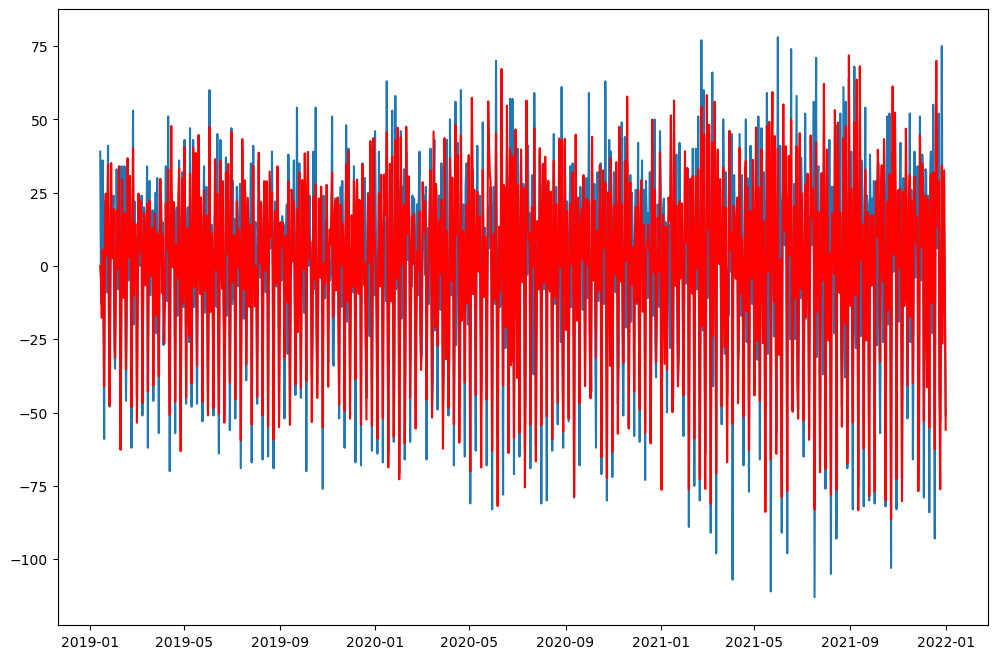

In [14]:
# Lets try diffrent parameters
model = ARIMA(webusersts_diff, order=(8, 0, 0))  
results_AR8 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(webusersts_diff)
plt.plot(results_AR8.fittedvalues, color='red')

In [31]:
results_AR8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1084
Model:                 ARIMA(8, 0, 0)   Log Likelihood               -4512.285
Date:                Mon, 20 May 2024   AIC                           9044.570
Time:                        21:03:16   BIC                           9094.454
Sample:                    01-14-2019   HQIC                          9063.455
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.078     -0.028      0.978      -0.154       0.150
ar.L1         -0.8545      0.029    -29.315      0.000      -0.912      -0.797
ar.L2         -0.9568      0.038    -25.095      0.000      -1.032      -0.882
ar.L3         -0.8675      0.043    -20.314      0.000      -0.951      -0.784
ar.L4         -0.8298      0.041    -20.012      0.000      -0.911      -0.749
ar.L5         -0.9215      0.042    -21.995      0.000      -1.004      -0.839
ar.L6         -0.7008      0.043    -16.371      0.000      -0.785      -0.617
ar.L7         -0.0528      0.038     -1.373      0.170      -0.128       0.023
ar.L8          0.0638      0.031      2.032      0.042       0.002       0.125
sigma2       240.4000     10.305     23.329      0.000     220.203     260.597
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.85   Prob(JB):                         0.83
Heteroskedasticity (H):               2.09   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The AIC value is lower than for ARIMA(6,0,0)

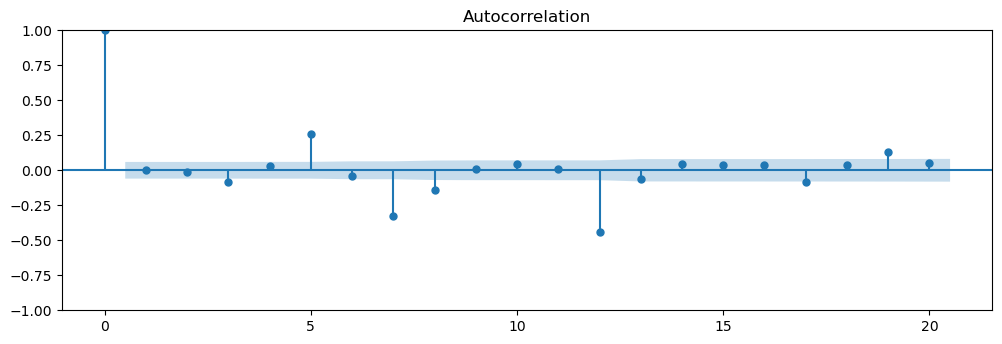

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR8.resid, lags=20, ax=ax1)

The third and fifth lag are autocorrelated.

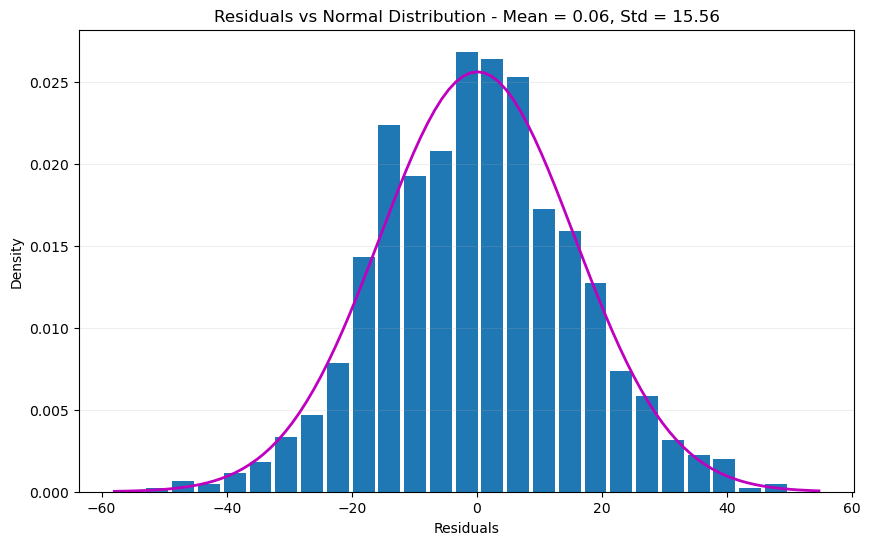

In [33]:
resid_histogram(results_AR8.resid)

Model Residual is close to normal distribution.

In [21]:
# ARIMA forecast of (6,0,0) and (8,0,0)
Fcast600 = results_AR6.predict(start = '01/01/2022',
                               end = '01/06/2022')

In [22]:
Fcast800 = results_AR8.predict(start = '01/01/2022',
                                end = '02/06/2022')

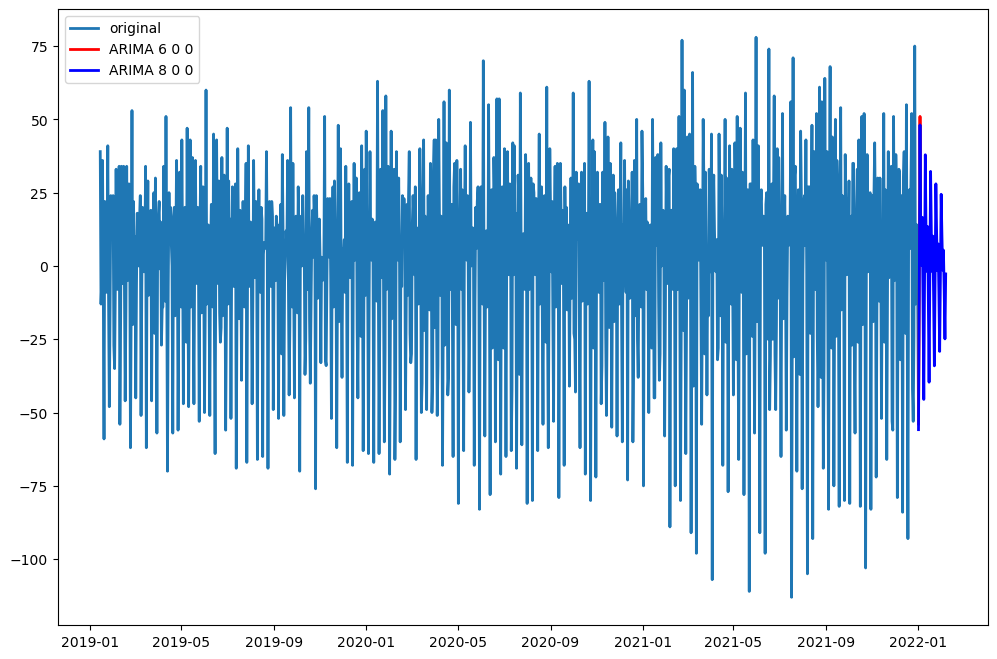

In [23]:
# Forecast comparison
plt.figure(figsize = (12, 8))
plt.plot(webusersts_diff, linewidth = 2, label = "original")
plt.plot(Fcast600, color='red', linewidth = 2,
         label = "ARIMA 6 0 0")
plt.plot(Fcast800, color='blue', linewidth = 2,
         label = "ARIMA 8 0 0")
plt.legend()

It is seems that model ARIMA(8,0,0) performs slightly better then ARIMA(6,0,0)